# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

Обозначения столбцов:

    - id — уникальный идентификатор скважины;
    - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    - product — объём запасов в скважине (тыс. баррелей).

In [3]:
def vusial(geo):
    a = geo.info()
    s = geo.head()
    d = sns.heatmap(geo.corr(), annot=True, square=True, cmap=sns.cubehelix_palette(as_cmap=True));
    return a, s, d

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(None,
       id        f0        f1        f2     product
 0  txEyH  0.705745 -0.497823  1.221170  105.280062
 1  2acmU  1.334711 -0.340164  4.365080   73.037750
 2  409Wp  1.022732  0.151990  1.419926   85.265647
 3  iJLyR -0.032172  0.139033  2.978566  168.620776
 4  Xdl7t  1.988431  0.155413  4.751769  154.036647,
 <AxesSubplot:>)

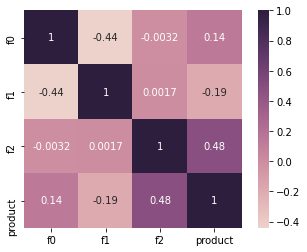

In [4]:
vusial(geo_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(None,
       id         f0         f1        f2     product
 0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
 1  62mP7  14.272088  -3.475083  0.999183   26.953261
 2  vyE1P   6.263187  -5.948386  5.001160  134.766305
 3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
 4  AHL4O  12.702195  -8.147433  5.004363  134.766305,
 <AxesSubplot:>)

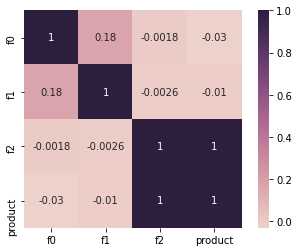

In [5]:
vusial(geo_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(None,
       id        f0        f1        f2     product
 0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
 1  WJtFt  0.262778  0.269839 -2.530187   56.069697
 2  ovLUW  0.194587  0.289035 -5.586433   62.871910
 3  q6cA6  2.236060 -0.553760  0.930038  114.572842
 4  WPMUX -0.515993  1.716266  5.899011  149.600746,
 <AxesSubplot:>)

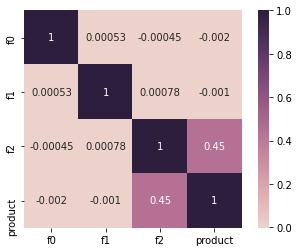

In [6]:
vusial(geo_2)

Тип данных в каждом датафрейме правильный, как и названия столбцов.

Наблюдаются ли зависимости? Если судить по корреляции, то самый независимый geo_2, после него идёт geo_0, у них двоих схожая зависимость признака точки f2 от product (0.45-0.48), а вот у geo_1 есть такая же зависимсоть, но она равна единице. В общем, во всех трех датафреймах наблюдается корреляция целевого признака с признаком f2.
/
### Вывод
    - ознакомились с данными
    - рассмотрели коэфф.корреляции, обнаружили что он достаточно высок между целевым признаком product и признаком f2

## Обучение и проверка модели

In [7]:
def get_result_model (geo, name):
    features = geo.drop(['id', 'product'], axis = 1)
    target = geo['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=.25, random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid, predict))**0.5
    
    print(name)
    print('Средний запас сырья, тыс. баррелей:', predict.mean())   
    print('RMSE:', rmse)
    
    return target_valid.mean(), predict, target_valid

In [8]:
g0, pg0, tg0 = get_result_model(geo_0, '№1')

№1
Средний запас сырья, тыс. баррелей: 92.59256778438035
RMSE: 37.5794217150813


In [9]:
g1, pg1, tg1 = get_result_model(geo_1, '№2')

№2
Средний запас сырья, тыс. баррелей: 68.728546895446
RMSE: 0.893099286775617


In [10]:
g2, pg2, tg2 = get_result_model(geo_2, '№3')

№3
Средний запас сырья, тыс. баррелей: 94.96504596800489
RMSE: 40.02970873393434


### Вывод
    - самые большие запасы сырья в 3 регионе
    - модель 2 региона имеет самую низкую оценку RMSE, можно предположить, что она самая точная/качественная, также она имеет самый низний средний запас сырья
    - качество моделей 1 и 3 региона существенно ниже

## Подготовка к расчёту прибыли

In [11]:
INVESTIGATED = 500
OIL_NUMBER = 200

BUDGET_REGION = 10_000_000_000
BUDGET_ONE = BUDGET_REGION / OIL_NUMBER

BARREL_PRICE = 450_000

MAX_RISK = 0.025

PAYBACK_MIN = round(BUDGET_ONE / BARREL_PRICE, 2)

In [12]:
print(f'Минимальный необходимый средний запас в месторождениях региона: {PAYBACK_MIN} тыс. баррелей.')

Минимальный необходимый средний запас в месторождениях региона: 111.11 тыс. баррелей.


In [13]:
print('Разность между мин. необходимым средним запасом сырья и средним истинным запасом сырья:')
print(f'Регион №1 {PAYBACK_MIN-g0}')
print(f'Регион №2 {PAYBACK_MIN-g1}')
print(f'Регион №3 {PAYBACK_MIN-g2}')

Разность между мин. необходимым средним запасом сырья и средним истинным запасом сырья:
Регион №1 19.03140325917073
Регион №2 42.386863975640026
Регион №3 16.22576719114562


### Вывод
    - минимальный необходимый средний запас в месторождениях региона: 111.11 тыс. баррелей.
    - если смотреть на разность, то проект будет убыточным в любом регионе
    - потребуется найти скважины, где истинный запас превысит среднюю оценку по региону не менее чем на 16-43 тыс. баррелей, и составит не менее 111.11 тыс. баррелей.

## Расчёт прибыли и рисков 

In [14]:
state = np.random.RandomState(12345)

In [15]:
def revenue(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:OIL_NUMBER]
    return ((BARREL_PRICE * selected.sum()) - BUDGET_REGION) / 1_000_000_000

def bootstrap (target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=INVESTIGATED, replace=True, random_state=state)
        probs_subsample = predictions[target_subsample.index]
        rev = revenue(target_subsample, probs_subsample)
        values.append(rev)

    values = pd.Series(values)
    confidence_interval = st.t.interval(0.975, len(values)-1, values.mean(), values.sem())
    confidence_interval2 = ((values.quantile(0.025)), values.quantile(0.975))
    mean = values.mean()

    print("Средняя выручка:", mean)
    print("Доверительный интервал для истинного среднего генеральной совокупности:", confidence_interval)
    print("Доверительный интервал для распределения прибыли:", confidence_interval2)
    print("Риски убытка:", ((values < 0).mean())*100, "%")

In [16]:
bootstrap(tg0, pg0)

Средняя выручка: 0.3961649848023711
Доверительный интервал для истинного среднего генеральной совокупности: (0.37723899669885724, 0.41509097290588504)
Доверительный интервал для распределения прибыли: (-0.11121554589049526, 0.9097669415534225)
Риски убытка: 6.9 %


In [17]:
bootstrap(tg1, pg1)

Средняя выручка: 0.46115581727723964
Доверительный интервал для истинного среднего генеральной совокупности: (0.4470546956371293, 0.47525693891735)
Доверительный интервал для распределения прибыли: (0.07805081075174171, 0.8629520602637234)
Риски убытка: 0.7000000000000001 %


In [18]:
bootstrap(tg2, pg2)

Средняя выручка: 0.39295047517060455
Доверительный интервал для истинного среднего генеральной совокупности: (0.373748135599566, 0.41215281474164317)
Доверительный интервал для распределения прибыли: (-0.11222762537857565, 0.9345629145511635)
Риски убытка: 6.5 %


### Вывод
    - только второй регион подходит для бурения скважин, у него самые низкие риски убытка и самая большая средняя выручка